In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.metrics import accuracy_score,log_loss,mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import seaborn as sn
from numpy.linalg import norm
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

In [46]:
my_cmap=matplotlib.colors.LinearSegmentedColormap.from_list("",["red","black","orange","black","yellow"])

In [13]:
np.random.seed(0)

In [47]:
iris=load_iris()
data=iris.data[:,:2]
target=iris.target
#target=target.reshape(-1,1)
target.shape


(150,)

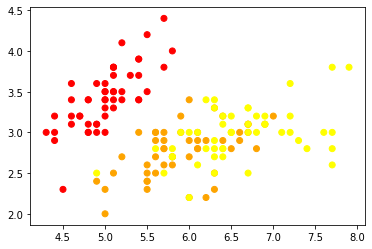

In [48]:
plt.scatter(data[:,0],data[:,1],c=target,cmap=my_cmap)
plt.show()

In [86]:
X_train,X_val,Y_train,Y_val=train_test_split(data,target,stratify=target,random_state=0)
print(X_train.shape,X_val.shape)


(112, 2) (38, 2)


AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

In [87]:
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)

imputer = imputer.fit(X_train)

X_train = imputer.transform(X_train)

C:\Users\rjgen\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [88]:
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)

imputer = imputer.fit(X_val)

X_val = imputer.transform(X_val)

C:\Users\rjgen\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [54]:
enc=OneHotEncoder()
Y_enc_train=enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_enc_val=enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(Y_enc_train.shape)

C:\Users\rjgen\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\rjgen\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

(112, 3)


In [92]:
class FNN:
    def __init__(self,init_method="random",activation="sigmoid",leaky_slope=0.1):
        
        self.params={}
        self.params_h=[]
        self.num_layers=2
        self.layer_size=[2,2,3]
        self.activation_function=activation
        self.leaky_slope=leaky_slope
        
        np.random.seed(0)
        
        if init_method=="random":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_size[i-1],self.layer_size[i])
                self.params["B"+str(i)]=np.random.randn(1,self.layer_size[i])
        
        elif init_method=="he":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_size[i-1],self.layer_size[i])*(np.sqrt(2)/np.sqrt(self.layer_size[i-1]))
                self.params["B"+str(i)]=np.random.randn(1,self.layer_size[i])

        elif init_method=="xavier":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_size[i-1],self.layer_size[i])*(1.0/np.sqrt(self.layer_size[i-1]))
                self.params["B"+str(i)]=np.random.randn(1,self.layer_size[i])
        
        elif init_method == "zeros":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.zeros((self.layer_size[i-1],self.layer_size[i]))
                self.params["B"+str(i)]=np.zeros((1,self.layer_size[i]))
        
        self.gradients={}
        self.update_params={}
        self.prev_update_params={}
        for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)]=0
            self.update_params["v_b"+str(i)]=0
            self.update_params["m_b"+str(i)]=0
            self.update_params["m_w"+str(i)]=0
            self.prev_update_params["v_w"+str(i)]=0
            self.prev_update_params["v_b"+str(i)]=0
        
    def forward_activation(self,X):
        if(self.activation_function=="sigmoid"):
            return 1.0/(1.0+np.exp(-X))
        elif(self.activation_function=="tanh"):
            return np.tanh(X)
        elif(self.activation_function=="relu"):
            return np.maximum(0,X)
        elif(self.activation_function=="leaky_relu"):
            return np.maximum(self.leaky_slope*X,X)
    
    def grad_activation(self,X):
        if self.activation_function == "sigmoid":
            return X*(1-X)
        elif self.activation_function == "tanh":
            return 1-np.square(X)
        elif self.activation_function == "relu":
            return 1*(X>0)
        elif self.activation_function == "leaky_relu":
            d=np.zeros_like(X)
            d[X<=0]=self.leaky_slope
            d[X>0]=1
            return d
    
    def softmax(self,X):
        exps=np.exp(X)
        return exps/np.sum(exps,axis=1).reshape(-1,1)
            
    
    def forward_pass(self,X,params):
        if params is None:
            params=self.params
        self.A1=np.matmul(X,params["W1"])+params["B1"]
        self.H1=self.forward_activation(self.A1)
        self.A2=np.matmul(X,params["W2"])+params["B2"]
        self.H2=self.forward_activation(self.A2)
        return self.H2
    
    def grad(self,X,Y,params=None):
        if params is None:
            params=self.params
        self.forward_pass(X,params)
        m=X.shape[0]
        self.gradients["dA2"]=self.H2-Y
        self.gradients["dW2"]=np.matmul(self.H1.T,self.gradients["dA2"])
        self.gradients["dB2"]=np.sum(self.gradients["dA2"],axis=0).reshape(1,-1)
        self.gradients["dH1"]=np.matmul(self.gradients["dA2"],self.params["W2"].T)
        self.gradients["dA1"]=np.multiply(self.gradients["dH1"],self.grad_activation(self.H1))
        self.gradients["dW1"]=np.matmul(X.T,self.gradients["dA1"])
        self.gradients["dB1"]=np.sum(self.gradients["dA1"],axis=0).reshape(1,-1)
    
    def fit(self,X,Y,epochs=1,eta=1,l2_norm=False,lambda_val=0.1,display_loss=True):
        train_accuracies={}
        val_accuracies={}
        if display_loss:
            loss=[]
            weight_mag=[]
        
        for num_epoch in tqdm_notebook(range(epochs),total=epochs,unit="epoch"):
            m=X.shape[0]
            
            self.grad(X,Y)
            for i in range(1,self.num_layers+1):
                if norm :
                    self.params["W"+str(i)]-=(eta*lambda_val)/m * self.params["W"+str(i)] + eta*(self.gradients["dW"+str(i)]/m)
                else:
                    self.params["W"+str(i)]-=eta*(self.gradients["dW"+str(i)]/m)
                self.params["B"+str(i)]-=eta*self.gradients["dB"+str(i)]
            train_accuracy,val_accuracy=self.get_accuracy()
            train_accuracies[num_epoch]=train_accuracy
            val_accuracies[num_epoch]=val_accuracy
            if display_loss:
                Y_pred=self.predict(X)
                loss.append(log_loss(np.argmax(Y,axis=1),Y_pred))
                weight_mag.append((norm(self.params["W1"])+norm(self.params["W2"])+norm(self.params["B1"])+norm(self.params["B2"])))
        plt.plot(np.array(list(train_accuracies)).astype("float"),label="Train Accuracies")
        plt.plot(np.array(list(val_accuracies)).astype("float"),label="Validation Accuracies")
        plt.plot(np.ones((epochs,1))*0.9)
        plt.plot(np.ones((epochs,1))*0.33)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        
    def get_accuracy(self):
        Y_pred_train=model.predict(X_train)
        Y_pred_train=np.argmax(Y_pred_train,1)
        Y_pred_val=model.predict(X_val)
        Y_pred_val=np.argmax(Y_pred_val,1)
        accuracy_train=accuracy_score(Y_pred_train,Y_train)
        accuracy_val=accuracy_score(Y_pred_val,Y_val)
        return accuracy_train,accuracy_val
    def predict(self,X):
        Y_pred=self.forward_pass(X,None)
        return np.array(Y_pred).squeeze()


In [93]:
def print_accuracy(scatter_plot=True,gradient_plot=False,plot_scale=0.1):
    Y_pred_train=model.predict(X_train)
    Y_pred_train=np.argmax(Y_pred_train,1)
    Y_pred_val=model.predict(X_val)
    Y_pred_val=np.argmax(Y_pred_val,1)
    accuracy_train=accuracy_score(Y_pred_train,Y_train)
    accuracy_val=accuracy_score(Y_pred_val,Y_val)
    print("Training accuracy : ",round(accuracy_train,4))
    print("Validation accuracy : ",round(accuracy_val,4))
    
    if scatter_plot :
        plt.scatter(X_train[:,0],X_train[:,1],c=Y_pred_train,cmap=my_cmap,s=15*(np.abs(np.sign(Y_pred_train-Y_train))))
        plt.show()
    

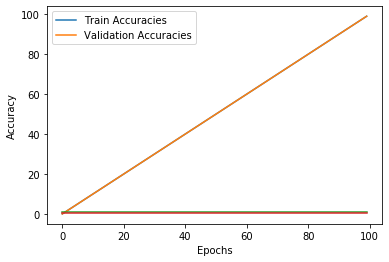

Training accuracy :  0.3304
Validation accuracy :  0.3421


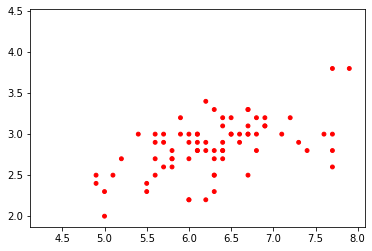

In [94]:
model=FNN(init_method="he",activation="relu")
model.fit(X_train,Y_enc_train,epochs=100,eta=0.5,l2_norm=False,display_loss=True)
print_accuracy()

Adding noise to Data

In [97]:
for noise_fraction in [0.01,0.05,0.1,0.15,0.18]:
    print(noise_fraction)
    X_train_noisy=X_train*(1-noise_fraction*np.random.randn(X_train.shape[0],X_train.shape[1]))


0.01
0.05
0.1
0.15
0.18


Early_stoppping